In [1]:
pip install opencv-python scikit-learn matplotlib tqdm

In [2]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [3]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np

def load_cifar10_torch(n_samples=10000):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Select first n_samples only and convert images to uint8
    X = []
    y = []

    for i in range(n_samples):
        img, label = dataset[i]
        img = img.numpy().transpose(1, 2, 0) * 255  # Convert to HWC format and scale to [0, 255]
        X.append(img.astype(np.uint8))  # Append the image
        y.append(label)  # Append the label

    X = np.array(X)
    y = np.array(y)

    return X, y

In [4]:
# Resize image and convert to grayscale
def preprocess_image(img, size=(128, 128)):
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

In [5]:
# Extract ORB and HOG features
def extract_features(img):
    # ORB descriptors
    orb = cv2.ORB_create(nfeatures=200)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    if descriptors is None:
        descriptors = np.zeros((1, 32))  # fallback
    return descriptors

In [6]:
# Extract HOG descriptors
def extract_hog(img):
    hog = cv2.HOGDescriptor()
    h = hog.compute(img)
    return h.flatten()

In [7]:
# Create BoVW feature vector
def compute_bovw(descriptor_list, k=100):
    all_descriptors = np.vstack(descriptor_list)
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=k*3)
    kmeans.fit(all_descriptors)
    bovw_features = []
    for desc in descriptor_list:
        words = kmeans.predict(desc)
        hist, _ = np.histogram(words, bins=np.arange(k+1))
        bovw_features.append(hist)
    return np.array(bovw_features), kmeans

In [8]:
def run_pipeline():
    X, y = load_cifar10_torch(n_samples=10000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    orb_descriptors_train = []
    hog_features_train = []

    print("Extracting features from training images...")
    for img in tqdm(X_train):
        gray = preprocess_image(img)
        orb_desc = extract_features(gray)
        hog_feat = extract_hog(gray)
        orb_descriptors_train.append(orb_desc)
        hog_features_train.append(hog_feat)

    print("Building Bag of Visual Words...")
    bovw_train, kmeans = compute_bovw(orb_descriptors_train, k=100)

    # Combine BoVW and HOG features
    hog_features_train = np.array(hog_features_train)
    combined_train = np.hstack((bovw_train, hog_features_train))

    # Scale features
    scaler = StandardScaler()
    combined_train = scaler.fit_transform(combined_train)

    print("Training SVM...")
    clf = SVC(kernel='linear', C=1.0)
    clf.fit(combined_train, y_train)

    # ---- TESTING ----
    print("Extracting features from test images...")
    orb_descriptors_test = []
    hog_features_test = []
    for img in tqdm(X_test):
        gray = preprocess_image(img)
        orb_desc = extract_features(gray)
        hog_feat = extract_hog(gray)
        orb_descriptors_test.append(orb_desc)
        hog_features_test.append(hog_feat)

    bovw_test = []
    for desc in orb_descriptors_test:
        words = kmeans.predict(desc)
        hist, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1))
        bovw_test.append(hist)
    bovw_test = np.array(bovw_test)

    hog_features_test = np.array(hog_features_test)
    combined_test = np.hstack((bovw_test, hog_features_test))
    combined_test = scaler.transform(combined_test)

    print("Evaluating...")
    y_pred = clf.predict(combined_test)
    print(classification_report(y_test, y_pred))

    return y_test, y_pred, clf, combined_test  # for further plotting


In [9]:
y_test, y_pred, clf, combined_test = run_pipeline()

Extracting features from training images...


100%|██████████| 8000/8000 [00:34<00:00, 232.94it/s]


Building Bag of Visual Words...
Training SVM...
Extracting features from test images...


100%|██████████| 2000/2000 [00:03<00:00, 623.67it/s]


Evaluating...
              precision    recall  f1-score   support

           0       0.50      0.57      0.53       207
           1       0.65      0.69      0.67       213
           2       0.28      0.34      0.31       197
           3       0.29      0.31      0.30       199
           4       0.42      0.40      0.41       205
           5       0.32      0.32      0.32       177
           6       0.51      0.53      0.52       187
           7       0.59      0.51      0.54       200
           8       0.58      0.54      0.56       224
           9       0.67      0.53      0.59       191

    accuracy                           0.48      2000
   macro avg       0.48      0.47      0.48      2000
weighted avg       0.49      0.48      0.48      2000



In [12]:
from sklearn.metrics import classification_report
import pandas as pd

def plot_model_evaluation(y_test, y_pred, clf, combined_test):
    num_classes = len(np.unique(y_test))

    # --- Confusion Matrix ---
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(ax=ax1)
    plt.title("Confusion Matrix")
    plt.tight_layout()

    # --- Accuracy Heatmap ---
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="YlGnBu",
                xticklabels=False, yticklabels=False)
    ax2.set_title("Accuracy Heatmap")
    ax2.set_xlabel("Predicted Label")
    ax2.set_ylabel("True Label")
    plt.tight_layout()

    # --- Precision-Recall Curve ---
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(combined_test)
        y_test_bin = label_binarize(y_test, classes=range(num_classes))

        fig3, ax3 = plt.subplots(figsize=(10, 8))
        for i in range(min(10, num_classes)):  # Only first 10 for visibility
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ax3.plot(recall, precision, label=f"Class {i}")
        ax3.set_title("Precision-Recall Curves (Top 10 Classes)")
        ax3.set_xlabel("Recall")
        ax3.set_ylabel("Precision")
        ax3.legend(loc="best")
        plt.tight_layout()

    # --- Precision, Recall, F1 Score Matrix ---
    print("\nGenerating Precision-Recall-F1 Matrix...")
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    # Drop average rows for per-class matrix
    report_df = pd.DataFrame(report_dict).T.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

    fig4, ax4 = plt.subplots(figsize=(12, min(25, 0.25 * len(report_df))))
    sns.heatmap(report_df[["precision", "recall", "f1-score"]].astype(float), annot=True, fmt=".2f", cmap="Blues", ax=ax4)
    ax4.set_title("Precision, Recall, F1-score per Class")
    ax4.set_xlabel("Metric")
    ax4.set_ylabel("Class")
    plt.tight_layout()

    plt.show()



Generating Precision-Recall-F1 Matrix...


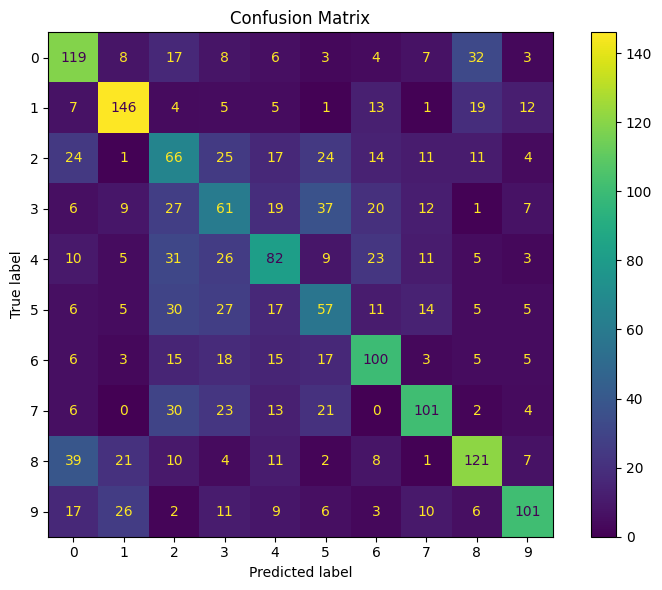

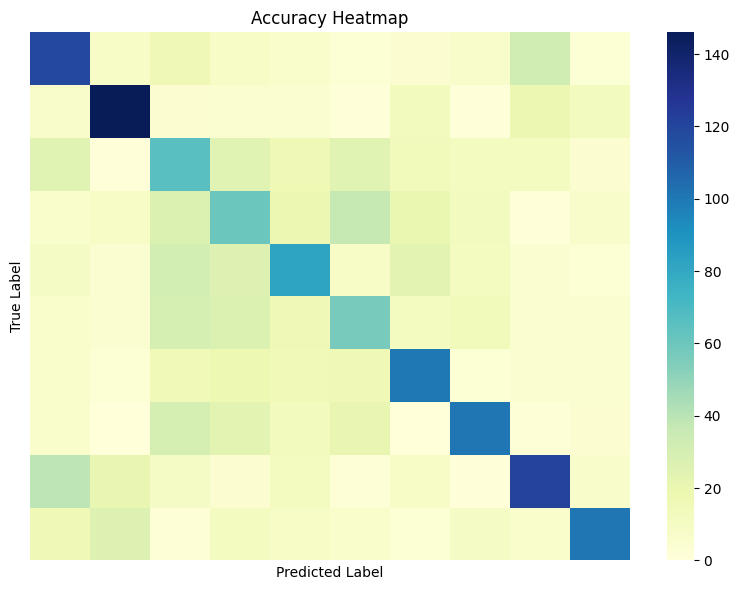

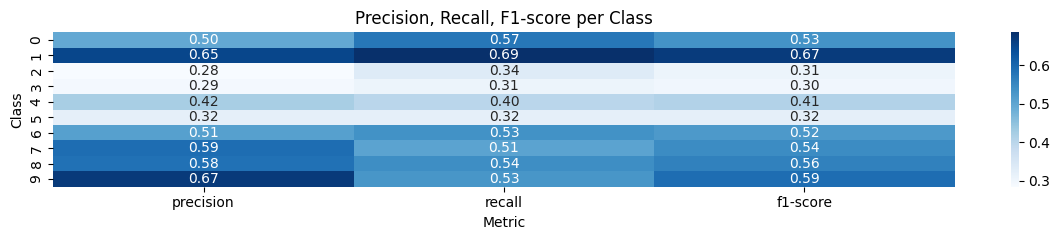

In [13]:
plot_model_evaluation(y_test, y_pred, clf, combined_test)

In [14]:
def plot_label_distribution(y_train, y_test):
    train_dist = pd.Series(y_train).value_counts().sort_index()
    test_dist = pd.Series(y_test).value_counts().sort_index()

    fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

    sns.barplot(x=train_dist.index, y=train_dist.values, ax=axs[0])
    axs[0].set_title("Training Label Distribution")
    axs[0].set_xlabel("Class Label")
    axs[0].set_ylabel("Count")

    sns.barplot(x=test_dist.index, y=test_dist.values, ax=axs[1])
    axs[1].set_title("Test Label Distribution")
    axs[1].set_xlabel("Class Label")

    plt.tight_layout()
    plt.show()